In [1]:
import time
start_simulation = time.time()

import numpy as np
import scipy as sc

import bsplines  as bsp

import HyCho_FEM as fem
import HyCho_PIC

import matplotlib.pyplot as plt

from scipy.sparse.linalg import splu
from scipy.sparse        import block_diag
from scipy.sparse.linalg import inv

import scipy.special as sp


#====================================================================================
#  calling epyccel
#====================================================================================
from pyccel.epyccel import epyccel
pic = epyccel(HyCho_PIC)

print('pyccelization of pic functions done!')
#====================================================================================



#=========================== time integration =======================================
time_integr = 0                                                 # do time integration? (1 : yes, 0: no)

#identifier  = 'run_L=327.7_Nel=3400_T=5000_dt=0.02_Np=1.5e7_nuh=6e-3_xi=8.62e-5_bc=False_k=none_p=2_CV=off_amp=none_rel=on_wperp=0.55_local'  # name of saved files

identifier  = 'test_new'

dir_results = 'results/'                                        # directory of where to save results
dir_restart = 'restart_files/'                                  # directory of where to save restart files
#====================================================================================




#===== Is this run a restart? (restart = 0: no, restart = 1: yes) ===================
restart            = 0

max_time           = 100*60         # maximum runtime of program in minutes
time_restart_files = 120*60         # time interval for restart files in minutes

# names of restart files
name_particles     = 'restart_files/' + identifier + '_restart=particles1.npy'
name_fields        = 'restart_files/' + identifier + '_restart=fields1.npy'
name_time_step     = 'restart_files/' + identifier + '_restart=time1.npy'
name_control       = 'restart_files/' + identifier + '_restart=CV1.npy'
#====================================================================================





#===== physical parameters ==========================================================
wpe   = 5.                         # cold electron plasma frequency
nuh   = 6e-3                       # ratio of cold/hot electron densities (nh/nc)
nh    = nuh*wpe**2                 # hot electron density
wpar  = 0.2                        # parallel thermal velocity of energetic particles
wperp = 0.55                       # perpendicular thermal velocity of energetic particles
xi    = 8.62e-5                    # inhomogeneity factor of background magnetic field

rel   = 1                          # relativistic fast electrons? (1: yes, 0: no)
bc_d  = 1                          # damping of E and j at boundaries? (1: yes, 0: no)
bc_f  = 1                          # field line dependence of initial distribution function? (1: yes, 0: no)
#===================================================================================



#===== numerical parameters =========================================================
bc      = False                    # boundary conditions (True: periodic, False: homogeneous Dirichlet)
k       = 2.                       # wavenumber of initial wave field perturbations
Lz      = 325.                     # length of z-domain
Nel     = 5000                     # number of elements z-direction
T       = 0.4                      # simulation time
dt      = 0.02                     # time step
p       = 2                        # degree of B-spline basis functions in V0
Np      = np.int(1.3e6)            # number of markers
control = 0                        # control variate for noise reduction? (1: yes, 0: no)
Ld      = 0.046*Lz                 # length of damping region at each end
loading = 'importance sampling'    # particle loading 
                                   # 'random independently'
                                   # 'random simultaneously'
                                   # 'external loading'
                                   # 'importance sampling'

name_initial_particles = 'test_particles_Np=1.3e7_1.npy' # name of particle file if 'external loading'
#====================================================================================


#===== evaluation points for the magnetic field======================================
eva_points_Bx = np.array([100., 120., 140., 160., 180., 200.])
#====================================================================================


#===== initial conditions for fields ================================================
amp = 1e-4                         # amplitude of initial wave field perturbations

Ex0 = lambda z : 0*z               # initial Ex
Ey0 = lambda z : 0*z               # initial Ey

'''
def Bx0(z):
    
    value = 0.
    modes = 1 + np.arange(int(Nel/4))
    
    for i in range(int(Nel/4)):
        value += amp*np.random.rand()*np.sin(2*np.pi*modes[i]*z/Lz)
     
    return value
'''


Bx0 = lambda z : 0*z               # initial Bx
#Bx0 = lambda z : amp*np.sin(k*z)

By0 = lambda z : 0*z               # initial By
jx0 = lambda z : 0*z               # initial jcx
jy0 = lambda z : 0*z               # initial jcy
#====================================================================================



#===== discretization of spatial domain =============================================
dz   = Lz/Nel                                # element size
el_b = np.linspace(0., Lz, Nel + 1)          # element boundaries

Nbase0     = Nel + p - bc*p                  # total number of basis functions in V0
Nbase0_dof = Nbase0 - 2 + 2*bc               # number of degrees of freedom in V1

Nbase1     = Nbase0 - 1 + bc                 # total number of basis functions in V1
Nbase1_dof = Nbase1                          # number of degrees of freedom in V1
#====================================================================================



#===== some diagnostic values =======================================================
nh       = nuh*wpe**2                                 # hot electron density
Eh_eq    = Lz*nh/2*(wpar**2 + 2*wperp**2)             # equilibrium energetic electron energy

energies = np.empty(4, dtype=float)                   # energies: E, B, cold, hot

Bx       = np.empty(len(eva_points_Bx), dtype=float)  # x-component of magnetic field at some positions
#====================================================================================


#===== background field in z-direction ==============================================
B_background_z = lambda z : 1. + xi*(z - Lz/2)**2
#====================================================================================


#===== initial energetic electron distribution function =============================
def fh0(z, vx, vy, vz):

    xiB = 1. - 1/B_background_z(z)
    xiz = 1. + (wperp**2/wpar**2 - 1.)*xiB*bc_f

    return nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - xiz*(vx**2 + vy**2)/(2*wperp**2))
#====================================================================================



#===== Maxwellian for control variate ===============================================
def maxwell(z, vx, vy, vz):
    
    xiB = 1. - 1/B_background_z(z)
    xiz = 1. + (wperp**2/wpar**2 - 1.)*xiB*bc_f
    
    return nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - xiz*(vx**2 + vy**2)/(2*wperp**2))
#====================================================================================


#===== sampling distribution for initial markers ====================================
def g_sampling(z, vx, vy, vz):
    
    xiB = 1. - 1/B_background_z(z)
    xiz = 1. + (wperp**2/wpar**2 - 1.)*xiB*bc_f
    
    if xi == 0:
        normalization = 1.
    else:
        normalization = 1/(Ta + 1) + 2*Ta*np.arctan(np.sqrt(xi*(Ta + 1))*Lz/2)/(Lz*np.sqrt(xi)*(Ta + 1)**(3/2))
        
    return 1/((2*np.pi)**(3/2)*wpar*wperp**2*Lz*normalization)*np.exp(-vz**2/(2*wpar**2) - xiz*(vx**2 + vy**2)/(2*wperp**2))
#====================================================================================



#===== masking function to damp wave fields near boundaries =========================
def damp(z):

    if z <= Ld:
        return np.sin(np.pi*z/(2*Ld))
    elif z >= Lz - Ld:
        return np.sin(np.pi*(Lz - z)/(2*Ld))
    else:
        return 1
#====================================================================================



#===== spline knot vector, global mass matrices (in V0 and V1) and gradient matrix ==
T0 = bsp.make_knots(el_b, p, bc)
T1 = T0[1:-1]

M0 = fem.mass_V0(T0, p, bc)
M1 = fem.mass_V1(T0, p, bc)
MB = fem.mass_V0_B(T0, p, bc, B_background_z)

G  = sc.sparse.csc_matrix(fem.GRAD(T0, p, bc))

if bc == False:
    M0 = M0[1:-1, 1:-1]
    MB = MB[1:-1, 1:-1]
    
    G  = G[:, 1:-1]

    
D = sc.sparse.csr_matrix(bsp.collocation_matrix(T1, p - 1, eva_points_Bx, bc, normalize=True))
print('matrix assembly done!')
#====================================================================================



#=================== coefficients for pp-forms ======================================
if p == 3:
    pp_0 = np.asfortranarray([[1/6, -1/(2*dz), 1/(2*dz**2), -1/(6*dz**3)], [2/3, 0., -1/dz**2, 1/(2*dz**3)], [1/6, 1/(2*dz), 1/(2*dz**2), -1/(2*dz**3)], [0., 0., 0., 1/(6*dz**3)]])
    pp_1 = np.asfortranarray([[1/2, -1/dz, 1/(2*dz**2)], [1/2, 1/dz, -1/dz**2], [0., 0., 1/(2*dz**2)]])/dz
elif p == 2:
    pp_0 = np.asfortranarray([[1/2, -1/dz, 1/(2*dz**2)], [1/2, 1/dz, -1/dz**2], [0., 0., 1/(2*dz**2)]])
    pp_1 = np.asfortranarray([[1., -1/dz], [0., 1/dz]])/dz
else:
    print('Only cubic and quadratic splines implemented!')
#====================================================================================



#===== reserve memory for unknowns ==================================================
ex     = np.empty(Nbase0, dtype=float)
ey     = np.empty(Nbase0, dtype=float)
bx     = np.empty(Nbase1, dtype=float)
by     = np.empty(Nbase1, dtype=float)
yx     = np.empty(Nbase0, dtype=float)
yy     = np.empty(Nbase0, dtype=float)

uj     = np.empty(4*Nbase0_dof + 2*Nbase1_dof, dtype=float)
z_old  = np.empty(Np, dtype=float)
spans0 = np.empty(Np, dtype=int)

jh_x   = np.empty(Nbase0, dtype=float)
jh_y   = np.empty(Nbase0, dtype=float)

Fh     = np.zeros(4*Nbase0_dof + 2*Nbase1_dof, dtype=float)
#====================================================================================



#===== initial coefficients with commuting projectors ===============================
proj = fem.projectors_1d(T0, p, bc)

ex[:] = proj.PI_0(Ex0)
ey[:] = proj.PI_0(Ey0)
bx[:] = proj.PI_1(Bx0)
by[:] = proj.PI_1(By0)
yx[:] = proj.PI_0(jx0)
yy[:] = proj.PI_0(jy0)

if bc == False:
    uj[:] = np.concatenate((ex[1:-1], ey[1:-1], bx, by, yx[1:-1], yy[1:-1]))
    
else:
    uj[:] = np.concatenate((ex, ey, bx, by, yx, yy))

print('projection of initial fields done!')
#====================================================================================



#===== construct block matrices for field update ====================================
I  = sc.sparse.identity(Nbase1_dof)
A1 = sc.sparse.bmat([[M0, None, None, None, None, None],[None, M0, None, None, None, None], [None, None, I, None, None, None], [None, None, None, I, None, None], [None, None, None, None, M0, None], [None, None, None, None, None, M0]], format='csc')
A2 = sc.sparse.bmat([[None, None, None, G.T.dot(M1), -M0, None],[None, None, -G.T.dot(M1), None, None, -M0], [None, G, None, None, None, None], [-G, None, None, None, None, None], [wpe**2*M0, None, None, None, None, -MB], [None, wpe**2*M0, None, None, MB, None]], format='csc')

LHS = A1 - dt/2*A2
RHS = A1 + dt/2*A2

LU = sc.sparse.linalg.splu(LHS)
print('LU factorization done!')


if bc_d == 1:
    
    if bc == False:
        greville = bsp.greville(T0, p, bc)[1:-1]
        colloq = sc.sparse.csc_matrix(bsp.collocation_matrix(T0, p, greville, bc)[:, 1:-1])
    else:
        greville = bsp.greville(T0, p, bc)
        colloq = sc.sparse.csc_matrix(bsp.collocation_matrix(T0, p, greville, bc))
        
    g_greville = np.zeros(Nbase0_dof, dtype=float)
    
    for i in range(Nbase0_dof):
        g_greville[i] = damp(greville[i])
            
    G_greville = sc.sparse.diags(g_greville, 0)
    DAMP       = inv(colloq).dot(G_greville.dot(colloq))
             
else:
    DAMP = sc.sparse.identity(Nbase0_dof)
    
DAMP_block = sc.sparse.block_diag((DAMP, DAMP, sc.sparse.identity(Nbase1_dof), sc.sparse.identity(Nbase1_dof), DAMP, DAMP), format='csr')
print('damping assembly done!')
#====================================================================================


#===== create particles (z, vx, vy, vz, wk) and sample according to sampling distribution
particles = np.zeros((Np, 5), order='F', dtype=float)

if   loading == 'random independently': 
    particles[:, 0] = np.random.rand (Np)*Lz
    particles[:, 1] = np.random.randn(Np)*wperp
    particles[:, 2] = np.random.randn(Np)*wperp
    particles[:, 3] = np.random.randn(Np)*wpar
    
elif loading == 'random simultaneously':
    particles[:, :4] = np.random.rand(Np, 4)

    particles[:, 0]  = particles[:, 0]*Lz
    particles[:, 1]  = sp.erfinv(2*particles[:, 1] - 1)*wperp*np.sqrt(2)
    particles[:, 2]  = sp.erfinv(2*particles[:, 2] - 1)*wperp*np.sqrt(2)
    particles[:, 3]  = sp.erfinv(2*particles[:, 3] - 1)*wpar*np.sqrt(2)
    
elif loading == 'external loading':
    particles[:, :] = np.load(name_initial_particles)

    #particles[:, 0] = particles[:, 0]*Lz
    #particles[:, 1] = particles[:, 1]*wperp
    #particles[:, 2] = particles[:, 2]*wperp
    #particles[:, 3] = particles[:, 3]*wpar

    particles[:, 0]  = particles[:, 0]*Lz
    particles[:, 1]  = sp.erfinv(2*particles[:, 1] - 1)*wperp*np.sqrt(2)
    particles[:, 2]  = sp.erfinv(2*particles[:, 2] - 1)*wperp*np.sqrt(2)
    particles[:, 3]  = sp.erfinv(2*particles[:, 3] - 1)*wpar *np.sqrt(2)

elif loading == 'importance sampling':
    particles[:, :4] = np.random.rand(Np, 4)
    
    Ta               = wperp**2/wpar**2 - 1.
    d_normalization  = 1/(Ta + 1) + 2*Ta*np.arctan(np.sqrt(xi*(Ta + 1))*Lz/2)/(Lz*np.sqrt(xi)*(Ta + 1)**(3/2))
    d_constant       = Ta*np.arctan(np.sqrt(xi*(Ta + 1))*Lz/2)/(Lz*np.sqrt(xi)*(Ta + 1)**(3/2))
    
    Fz       = lambda U, z : U*d_normalization - z/(Lz*(Ta + 1)) - d_constant - Ta*np.arctan(np.sqrt(xi*(Ta + 1))*(z - Lz/2))/(Lz*np.sqrt(xi)*(Ta + 1)**(3/2))
    Fz_prime = lambda z    : -1/(Lz*(Ta + 1)) - Ta/(Lz*np.sqrt(xi)*(Ta + 1)**(3/2))*np.sqrt(xi*(Ta + 1))/(1 + xi*(Ta + 1)*(z - Lz/2)**2)
    
    # Newton method for particle position (inversion of cumulative distribution function)    
    for ip in range(Np):
    
        z_part = Lz/2
        U      = np.random.rand()

        while True:
            z_part = z_part - Fz(U, z_part)/Fz_prime(z_part)

            if np.abs(Fz(U, z_part)) < 1e-6:
                particles[ip, 0] = z_part
                break
                
        if ip%100000 == 0:
            print(str(ip) + ' particles loaded!')
    
    particles[:, 1]  = sp.erfinv(2*particles[:, 1] - 1)*wperp*np.sqrt(2)
    particles[:, 2]  = sp.erfinv(2*particles[:, 2] - 1)*wperp*np.sqrt(2)
    particles[:, 3]  = sp.erfinv(2*particles[:, 3] - 1)*wpar *np.sqrt(2)         
    
print('particle loading done!')    
spans0[:] = np.floor(particles[:, 0]/dz).astype(int) + p
#====================================================================================



#===== parameters for control variate ===============================================
g0 = g_sampling(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])
w0 = fh0(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])/g_sampling(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])
#====================================================================================



#===== initialize velocities by pushing back by -dt/2 and compute weights ===========
timea = time.time()

z_old[:] = particles[:, 0]

if bc == True:
    pic.pusher_periodic(particles, -dt/2, T0, T1, p, spans0, Lz, Nbase0, ex, ey, bx, by, pp_0, pp_1, rel)
else:
    pic.pusher_reflecting(particles, -dt/2, T0, T1, p, spans0, Lz, dz, ex, ey, bx, by, pp_0, pp_1, xi, rel)

particles[:, 0] = z_old


particles[:, 4] = w0 - control*maxwell(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])/g0

timeb = time.time()
print('time for particle push: ' + str(timeb - timea))
#====================================================================================


#===== test timing for hot current computation ======================================
timea = time.time()

pic.current(particles[:, 0], particles[:, 1:], T0, p, spans0, jh_x, jh_y, Nbase0, rel)

timeb = time.time()
print('time for hot current computation: ' + str(timeb - timea))
#====================================================================================


#===== test timing for linear solver ================================================
timea = time.time()

LU.solve(RHS.dot(uj) + dt*Fh)

timeb = time.time()
print('time for solving linear system: ' + str(timeb - timea))
#====================================================================================



#===== time integration by a time step dt ===========================================
def update():
    
    # ... save old positions
    z_old[:] = particles[:, 0]
    # ...
    
    
    # ... update particle velocities from n-1/2 to n+1/2 with fields at time n and positions from n to n+1 with velocities at n+1/2
    spans0[:] = np.floor(particles[:, 0]/dz).astype(int) + p
    
    if bc == True:
        pic.pusher_periodic(particles, dt, T0, T1, p, spans0, Lz, Nbase0, ex, ey, bx, by, pp_0, pp_1, rel)
    else:
        pic.pusher_reflecting(particles, dt, T0, T1, p, spans0, Lz, dz, ex, ey, bx, by, pp_0, pp_1, xi, rel)
    # ...
    
    
    # ... update weights with control variate
    #particles[:, 4] = w0 - control*maxwell(particles[:, 1], particles[:, 2], particles[:, 3])/g0
    particles[:, 4] = w0 - control*maxwell(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])/g0
    # ...
    
    
    # ... compute hot electron current densities
    spans0[:] = np.floor(1/2*(z_old + particles[:, 0])/dz).astype(int) + p
    
    pic.current(1/2*(z_old + particles[:, 0]), particles[:, 1:], T0, p, spans0, jh_x, jh_y, Nbase0, rel)
    # ...
     
    
    # ... assemble right-hand side of weak formulation
    if bc == True:
        Fh[0*Nbase0_dof:1*Nbase0_dof] = -jh_x
        Fh[1*Nbase0_dof:2*Nbase0_dof] = -jh_y
    else:
        Fh[0*Nbase0_dof:1*Nbase0_dof] = -jh_x[1:-1]
        Fh[1*Nbase0_dof:2*Nbase0_dof] = -jh_y[1:-1]
    # ...
    
    
    # ... time integration of E, B, jc from n to n+1 with Crank-Nicolson method (use hot current density at n+1/2) 
    uj[:] = DAMP_block.dot(LU.solve(RHS.dot(uj) + dt*Fh))
    # ...
       
        
        
    # ... diagnostics
    if bc == True:
        ex[:]  = uj[0*Nbase0_dof + 0*Nbase1_dof:1*Nbase0_dof + 0*Nbase1_dof]
        ey[:]  = uj[1*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 0*Nbase1_dof]
        bx[:]  = uj[2*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 1*Nbase1_dof]
        by[:]  = uj[2*Nbase0_dof + 1*Nbase1_dof:2*Nbase0_dof + 2*Nbase1_dof]
        yx[:]  = uj[2*Nbase0_dof + 2*Nbase1_dof:3*Nbase0_dof + 2*Nbase1_dof]
        yy[:]  = uj[3*Nbase0_dof + 2*Nbase1_dof:4*Nbase0_dof + 2*Nbase1_dof]
        
        energies[0] = 1/2      * (ex.dot(M0.dot(ex)) + ey.dot(M0.dot(ey)))
        energies[1] = 1/2      * (bx.dot(M1.dot(bx)) + by.dot(M1.dot(by)))
        energies[2] = 1/wpe**2 * (yx.dot(M0.dot(yx)) + yy.dot(M0.dot(yy)))
        energies[3] = 1/(2*Np) * particles[:, 4].dot(particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq
        
        Bx[:]  = D.dot(bx)
        
    else:
        ex[:]  = np.array([0] + list(uj[0*Nbase0_dof + 0*Nbase1_dof:1*Nbase0_dof + 0*Nbase1_dof]) + [0])
        ey[:]  = np.array([0] + list(uj[1*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 0*Nbase1_dof]) + [0])
        bx[:]  = uj[2*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 1*Nbase1_dof]
        by[:]  = uj[2*Nbase0_dof + 1*Nbase1_dof:2*Nbase0_dof + 2*Nbase1_dof]
        yx[:]  = np.array([0] + list(uj[2*Nbase0_dof + 2*Nbase1_dof:3*Nbase0_dof + 2*Nbase1_dof]) + [0])
        yy[:]  = np.array([0] + list(uj[3*Nbase0_dof + 2*Nbase1_dof:4*Nbase0_dof + 2*Nbase1_dof]) + [0])
        
        energies[0] = 1/2      * (ex[1:-1].dot(M0.dot(ex[1:-1])) + ey[1:-1].dot(M0.dot(ey[1:-1])))
        energies[1] = 1/2      * (bx.dot(M1.dot(bx)) + by.dot(M1.dot(by)))
        energies[2] = 1/wpe**2 * (yx[1:-1].dot(M0.dot(yx[1:-1])) + yy[1:-1].dot(M0.dot(yy[1:-1])))
        energies[3] = 1/(2*Np) * particles[:, 4].dot(particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq
    
        Bx[:]  = D.dot(bx)
    # ...
#====================================================================================








#============================ time loop =============================================
if time_integr == 1:
    
    if restart == 0:
        title = dir_results + identifier + '.txt'
        file = open(title, 'ab')
        
        # ... initial diagnostics
        if bc == True:
            energies[0]  = 1/2      * (ex.dot(M0.dot(ex)) + ey.dot(M0.dot(ey)))
            energies[1]  = 1/2      * (bx.dot(M1.dot(bx)) + by.dot(M1.dot(by)))
            energies[2]  = 1/wpe**2 * (yx.dot(M0.dot(yx)) + yy.dot(M0.dot(yy)))
            energies[3]  = 1/(2*Np) * particles[:, 4].dot(particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq

            Bx[:] = D.dot(bx)

        else:
            energies[0]  = 1/2      * (ex[1:-1].dot(M0.dot(ex[1:-1])) + ey[1:-1].dot(M0.dot(ey[1:-1])))
            energies[1]  = 1/2      * (bx.dot(M1.dot(bx)) + by.dot(M1.dot(by)))
            energies[2]  = 1/wpe**2 * (yx[1:-1].dot(M0.dot(yx[1:-1])) + yy[1:-1].dot(M0.dot(yy[1:-1])))
            energies[3]  = 1/(2*Np) * particles[:, 4].dot(particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq

            Bx[:] = D.dot(bx)
        # ...
        
        print('initial energies:', energies)
        
        
        
        
        #================ save initial data in this section ==========================
        #en_Bx = 1/2 * bx.dot(M1.dot(bx))
        
        data = np.concatenate((Bx, energies, np.array([0.])))
        np.savetxt(file, np.reshape(data, (1, 5 + len(eva_points_Bx))), fmt = '%1.10e')
        
        #data = np.concatenate((bx, energies, np.array([0.])))
        #np.savetxt(file, np.reshape(data, (1, 5 + len(bx))), fmt = '%1.10e')
        #=============================================================================
        
        
        
        time_step = 0
        counter   = 0
        
    else:
        #===== load restart data =====================================================
        title = dir_results + identifier + '.txt'
        file = open(title, 'ab')

        particles[:] = np.load(name_particles)
        uj[:]        = np.load(name_fields)
        w0           = np.load(name_control)[0]
        g0           = np.load(name_control)[1]
        time_step, counter = np.load(name_time_step)

        if bc == True:
            ex[:] = uj[0*Nbase0_dof + 0*Nbase1_dof:1*Nbase0_dof + 0*Nbase1_dof]
            ey[:] = uj[1*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 0*Nbase1_dof]
            bx[:] = uj[2*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 1*Nbase1_dof]
            by[:] = uj[2*Nbase0_dof + 1*Nbase1_dof:2*Nbase0_dof + 2*Nbase1_dof]
            yx[:] = uj[2*Nbase0_dof + 2*Nbase1_dof:3*Nbase0_dof + 2*Nbase1_dof]
            yy[:] = uj[3*Nbase0_dof + 2*Nbase1_dof:4*Nbase0_dof + 2*Nbase1_dof]
            
        else:
            ex[:] = np.array([0] + list(uj[0*Nbase0_dof + 0*Nbase1_dof:1*Nbase0_dof + 0*Nbase1_dof]) + [0])
            ey[:] = np.array([0] + list(uj[1*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 0*Nbase1_dof]) + [0])
            bx[:] = uj[2*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 1*Nbase1_dof]
            by[:] = uj[2*Nbase0_dof + 1*Nbase1_dof:2*Nbase0_dof + 2*Nbase1_dof]
            yx[:] = np.array([0] + list(uj[2*Nbase0_dof + 2*Nbase1_dof:3*Nbase0_dof + 2*Nbase1_dof]) + [0])
            yy[:] = np.array([0] + list(uj[3*Nbase0_dof + 2*Nbase1_dof:4*Nbase0_dof + 2*Nbase1_dof]) + [0])
        #=============================================================================
        
        
    print('start time integration! (number of time steps : ' + str(int(T/dt)) + ')')
    last_time = time.time()
        
        
    while True:

        try:
            if (time_step*dt >= T) or ((time.time() - start_simulation)/60 > max_time):

                counter += 1

                np.save(dir_restart + identifier + '_restart=particles' + str(counter), particles)
                np.save(dir_restart + identifier + '_restart=CV'        + str(counter), np.vstack((w0, g0)))
                np.save(dir_restart + identifier + '_restart=fields'    + str(counter), uj)
                np.save(dir_restart + identifier + '_restart=time'      + str(counter), np.array([time_step, counter]))

                break

            if time_step%50 == 0:
                print('time steps finished: ' + str(time_step))
                print('energies', energies)

            if (time.time() - last_time)/60 > time_restart_files:
                
                counter += 1

                np.save(dir_restart + identifier + '_restart=particles' + str(counter), particles)
                np.save(dir_restart + identifier + '_restart=CV'        + str(counter), np.vstack((w0, g0)))
                np.save(dir_restart + identifier + '_restart=fields'    + str(counter), uj)
                np.save(dir_restart + identifier + '_restart=time'      + str(counter), np.array([time_step, counter]))

                last_time = time.time()


                
                
            #========================= update and add new data to file ===============
            update()
            
            #en_Bx = 1/2 * bx.dot(M1.dot(bx))
        
            data = np.concatenate((Bx, energies, np.array([(time_step + 1)*dt])))
            np.savetxt(file, np.reshape(data, (1, 5 + len(eva_points_Bx))), fmt = '%1.10e')
            
            
            #data = np.concatenate((bx, energies, np.array([(time_step + 1)*dt])))
            #np.savetxt(file, np.reshape(data, (1, 5 + len(bx))), fmt = '%1.10e')
            #=========================================================================

            
            
            time_step += 1

        except KeyboardInterrupt:
            print('Pausing...  (Hit ENTER to continue, type quit to exit.)')

            file.close()

            try:
                response = input()
                if response == 'quit':
                    
                    counter += 1

                    np.save(dir_restart + identifier + '_restart=particles' + str(counter), particles)
                    np.save(dir_restart + identifier + '_restart=CV'        + str(counter), np.vstack((w0, g0)))
                    np.save(dir_restart + identifier + '_restart=fields'    + str(counter), uj)
                    np.save(dir_restart + identifier + '_restart=time'      + str(counter), np.array([time_step, counter]))
                    
                    break

                print('Resuming...')
                file = open(title, 'ab')

            except KeyboardInterrupt:

                print('Resuming...')
                continue

    file.close()
#===============================================================================================================

pyccelization of pic functions done!
matrix assembly done!
projection of initial fields done!
LU factorization done!
damping assembly done!
0 particles loaded!
100000 particles loaded!
200000 particles loaded!
300000 particles loaded!
400000 particles loaded!
500000 particles loaded!
600000 particles loaded!
700000 particles loaded!
800000 particles loaded!
900000 particles loaded!
1000000 particles loaded!
1100000 particles loaded!
1200000 particles loaded!
particle loading done!
time for particle push: 0.2782590389251709
time for hot current computation: 0.08422660827636719
time for solving linear system: 0.004591464996337891


In [3]:
particles[:, 4]

array([20.05091671, 20.05091671, 20.05091671, ..., 20.05091671,
       20.05091671, 20.05091671])

In [7]:
1/(Ta + 1) + 2*Ta*np.arctan(np.sqrt(xi*(Ta + 1))*Lz/2)/(Lz*np.sqrt(xi)*(Ta + 1)**(3/2))

0.4113008555844657

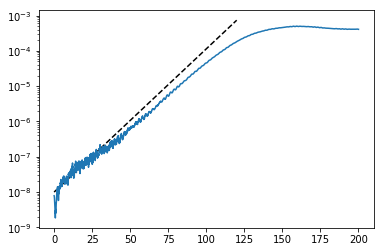

In [12]:
test = np.loadtxt('results/test_sobol.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(k, +1, 1., -1., wpe, wpar, wperp, nuh, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:3000], 1e-8*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

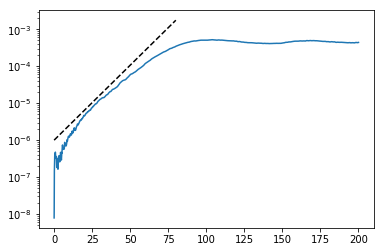

In [18]:
test = np.loadtxt('results/test_random.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(k, +1, 1., -1., wpe, wpar, wperp, nuh, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:2000], 1e-6*np.exp(2*tn[:2000]*np.imag(freq)), 'k--')

plt.semilogy(tn, en_B)

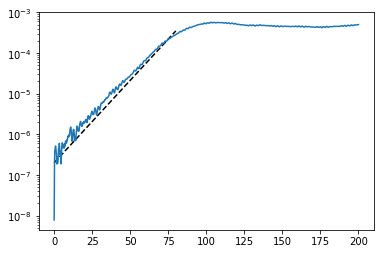

In [20]:
test = np.loadtxt('results/test_random.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(k, +1, 1., -1., wpe, wpar, wperp, nuh, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:2000], 2e-7*np.exp(2*tn[:2000]*np.imag(freq)), 'k--')

plt.semilogy(tn, en_B)

In [19]:
energies

array([7.77292203e-11, 7.77600999e-09, 3.88403349e-13, 2.03575244e-01])

In [86]:
energies = 

<HDF5 dataset "energies": shape (4,), type "<f4">

In [24]:
freq = fem.solveDispersionHybrid(k, +1, 1., -1., wpe, wpar, wperp, nuh, 0.5 + 0j, 1e-6, max_it=100)[0]

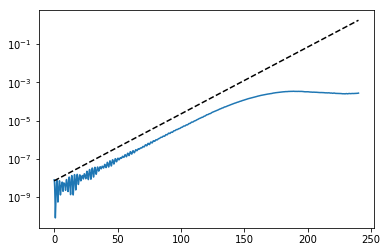

In [30]:
tn = np.linspace(0., T, Nt + 1)
plt.semilogy(tn, en_B)
plt.semilogy(tn, 7e-9*np.exp(2*tn*np.imag(freq)), 'k--')

In [44]:
freq = fem.solveDispersionHybridRelativistic(k, +1, 1., -1., wpe, wpar, wperp, nuh, 0.5, 1e-6, max_it=100)[1]

In [45]:
freq

0.02212578867867002

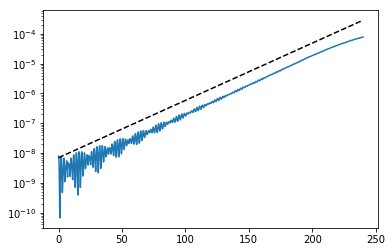

In [46]:
tn = np.linspace(0., T, Nt + 1)
plt.semilogy(tn, en_B)
plt.semilogy(tn, 7e-9*np.exp(2*tn*freq), 'k--')

In [5]:
D

<2x32 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [71]:
import sobol_seq
import scipy.special as sp
from scipy.stats import norm

particles[:, :4] = sobol_seq.i4_sobol_generate(4, Np)

particles[:, 1] = sp.erfinv(2*particles[:, 1] - 1)*wperp*np.sqrt(2)
particles[:, 2] = sp.erfinv(2*particles[:, 2] - 1)*wperp*np.sqrt(2)
particles[:, 3] = sp.erfinv(2*particles[:, 3] - 1)*wpar*np.sqrt(2)

#particles[:, 1] = norm.ppf(2*particles[:, 1] - 1)*wperp
#particles[:, 2] = norm.ppf(2*particles[:, 2] - 1)*wperp
#particles[:, 3] = norm.ppf(2*particles[:, 3] - 1)*wpar


np.random.shuffle(particles[:, 0])
np.random.shuffle(particles[:, 1])
np.random.shuffle(particles[:, 2])
np.random.shuffle(particles[:, 3])

(array([1.3000e+01, 6.3000e+01, 2.3100e+02, 7.1800e+02, 1.8770e+03,
        4.1230e+03, 7.5970e+03, 1.1758e+04, 1.5280e+04, 1.6674e+04,
        1.5280e+04, 1.1758e+04, 7.5960e+03, 4.1230e+03, 1.8770e+03,
        7.1800e+02, 2.3200e+02, 6.2000e+01, 1.4000e+01]),
 array([-2.12      , -1.89684211, -1.67368421, -1.45052632, -1.22736842,
        -1.00421053, -0.78105263, -0.55789474, -0.33473684, -0.11157895,
         0.11157895,  0.33473684,  0.55789474,  0.78105263,  1.00421053,
         1.22736842,  1.45052632,  1.67368421,  1.89684211,  2.12      ]),
 <a list of 19 Patch objects>)

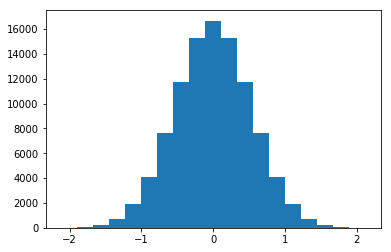

In [75]:
bins = np.linspace(-4*wperp, 4*wperp, 20)
plt.hist(particles[:, 1], bins=bins)
#plt.ylim((0., 16000.))

In [76]:
test = np.random.randn(Np)*wperp

(array([8.0000e+00, 5.4000e+01, 2.0700e+02, 6.7500e+02, 1.8360e+03,
        4.2360e+03, 7.7330e+03, 1.1934e+04, 1.5023e+04, 1.6441e+04,
        1.5287e+04, 1.1896e+04, 7.6470e+03, 4.0230e+03, 1.9510e+03,
        7.0700e+02, 2.3800e+02, 8.5000e+01, 1.4000e+01]),
 array([-2.12      , -1.89684211, -1.67368421, -1.45052632, -1.22736842,
        -1.00421053, -0.78105263, -0.55789474, -0.33473684, -0.11157895,
         0.11157895,  0.33473684,  0.55789474,  0.78105263,  1.00421053,
         1.22736842,  1.45052632,  1.67368421,  1.89684211,  2.12      ]),
 <a list of 19 Patch objects>)

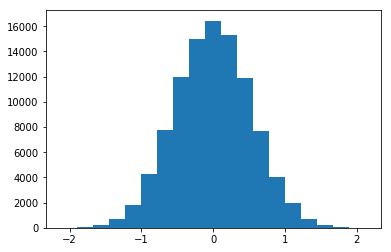

In [77]:
bins = np.linspace(-4*wperp, 4*wperp, 20)
plt.hist(test, bins=bins)